In [1]:
import scanpy as sc
import sys
sys.path.append("../")
import trvaep

## loading and preparing data 

In [2]:
adata = sc.read("../data/haber_count.h5ad", backup_url="shorturl.at/imuEP")
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var['highly_variable']]
n_conditions = adata.obs["condition"].unique().shape[0]

In [3]:
adata_train = adata[~((adata.obs["cell_label"] == "TA")
                      & (adata.obs["condition"] == "Hpoly.Day10"))]

In [4]:
sc.pp.neighbors(adata_train)
sc.tl.umap(adata_train)


         Falling back to preprocessing with `sc.pp.pca` and default params.


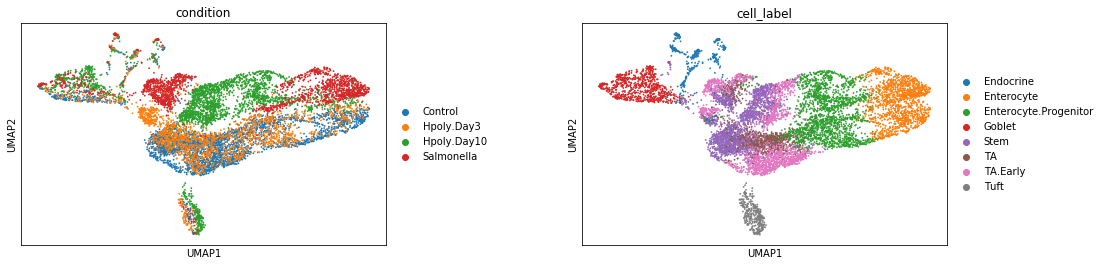

In [5]:
sc.pl.umap(adata_train, color=["condition", "cell_label"], wspace=.4)

## creating model object 

In [5]:
model = trvaep.CVAE(adata_train.n_vars, num_classes=n_conditions,
            encoder_layer_sizes=[64], decoder_layer_sizes=[64], latent_dim=10, alpha=0.0001,
            use_mmd=True, beta=1)

### Make a trainer object 


In [6]:
trainer = trvaep.Trainer(model, adata_train, print_every=2000)

In [ ]:
trainer.train_trvae(200, 512)

## visualizing the MMD latent space

You can use MMD layer representation for batch-removal

... storing 'cell_label' as categorical
... storing 'condition' as categorical


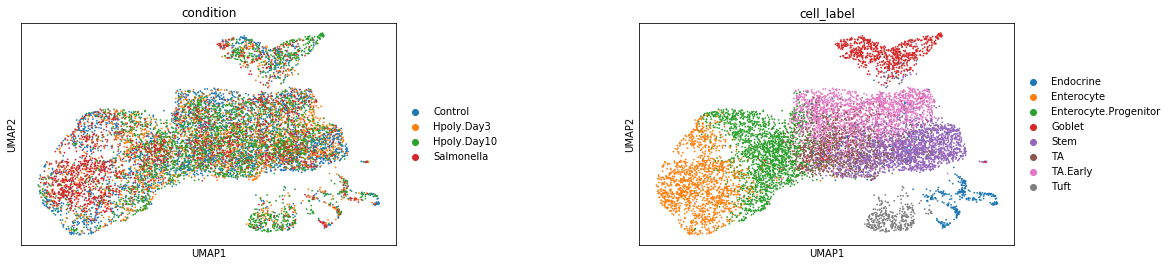

In [12]:
latent_y = model.get_y(
    adata.X, model.label_encoder.transform(adata.obs["condition"]))
adata_latent = sc.AnnData(latent_y)
adata_latent.obs["cell_label"] = adata.obs["cell_label"].tolist()
adata_latent.obs["condition"] = adata.obs["condition"].tolist()
sc.pp.neighbors(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent, color=["condition", "cell_label"], wspace=.5)

## Making prediction

... storing 'barcode' as categorical
... storing 'cell_label' as categorical
... storing 'condition' as categorical


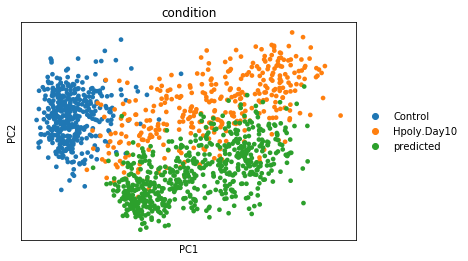

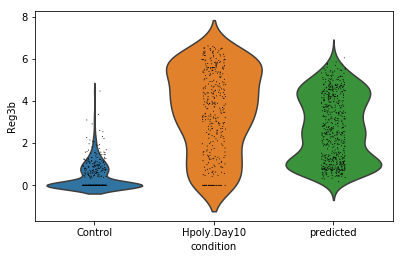

In [13]:
ground_truth = adata[((adata.obs["cell_label"] == "TA")
                      & (adata.obs["condition"].isin(["Hpoly.Day10", "Control"])))]
adata_source = adata[(adata.obs["cell_label"] == "Stem") &
                     (adata.obs["condition"] == "Hpoly.Day10")]
predicted_data = model.predict(x=adata_source.X, y=adata_source.obs["condition"].tolist(),
                               target="Hpoly.Day10")
adata_pred = sc.AnnData(predicted_data)
adata_pred.obs["condition"] = np.tile("predicted", len(adata_pred))
adata_pred.var_names = adata_source.var_names.tolist()
all_adata = ground_truth.concatenate(adata_pred)
sc.tl.pca(all_adata)
sc.pl.pca(all_adata, color=["condition"])
sc.pl.violin(all_adata, keys="Reg3b", groupby="condition")

## Reconstruct all data

In [ ]:
data = model.reconstruct(adata.X, model.label_encoder.transform(adata.obs["condition"]))
adata_rec = sc.AnnData(data)
adata_rec.obs["cell_label"] = adata.obs["cell_label"].tolist()
adata_rec.obs["condition"] = adata.obs["condition"].tolist()